# Space Environment Pathways
This Jupyter Notebook will allow users to play around with the scenarios, in order to get to know the laucnh data.

If you would like to use the scen_properties of a pickle file, then this must be located under the first pyssem folder. In the same folder as model.py

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

In [79]:
path = '/Users/isabellavesely/Downloads/SEP_files/ref_scen_SEP1.csv' # your path to the scenario csv file
T = pd.read_csv(path)

/var/folders/9y/hnc2c1bs54b27pqfzbnxv55r0000gn/T/ipykernel_32927/542347404.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  T = pd.read_csv(path)


### Isabella's New SEP Plotting
Now, we can run SEPTSoSpecies.py

In [80]:
from SEPSToSpecies_v2 import assign_species
assigned_df = assign_species(T)

Updated 45496 entries to phase 4 (debris).
Species counts (including NA) :
  N: 54441
  S: 7137
  <NA>: 5349
  B: 2082
  Su: 561
  Sns: 14


In [81]:
big_mass = 10000
heavy = assigned_df[assigned_df['mass'] > big_mass]

heavy = heavy[heavy['species_class']=="B"] # all others are NA
max_mass = heavy["mass"].max()

print(f"Number of objects > {big_mass} kg: {len(heavy)}")
print(heavy['species_class'].value_counts())
print(f"maximum mass: {max_mass}")

heavy


Number of objects > 10000 kg: 1
species_class
B    1
Name: count, dtype: int64
maximum mass: 21600.0


,obj_id,phase_desc,phase,par_id,operating_agency,const_name,const_shell_id,mass,area,diam_lcola,...,aop,ma,eci_x,eci_y,eci_z,eci_vx,eci_vy,eci_vz,obj_id_str,species_class
22644,22645,disposal,3,NaN,NaN,NaN,NaN,21600.0,35.9716,6.767604,...,332.5912,3.4229,-4834.478902,-5166.165746,36.549251,5.272106,-7.641679,3.087342,000000000000022645,B


These will be outliers we later remove in the statistical analysis for clustering!

In [82]:
remove_outliers = True

In [83]:
assigned_df['species_class'].dropna().unique()

array(['B', 'N', 'Su', 'Sns', 'S'], dtype=object)

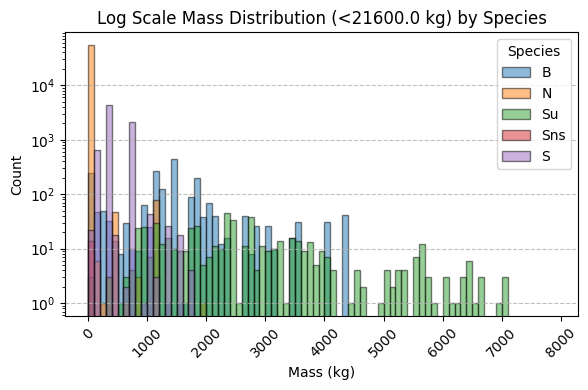

Length of data for B: 2081
Length of data for N: 54441
Length of data for Su: 561
Length of data for Sns: 14
Length of data for S: 7137


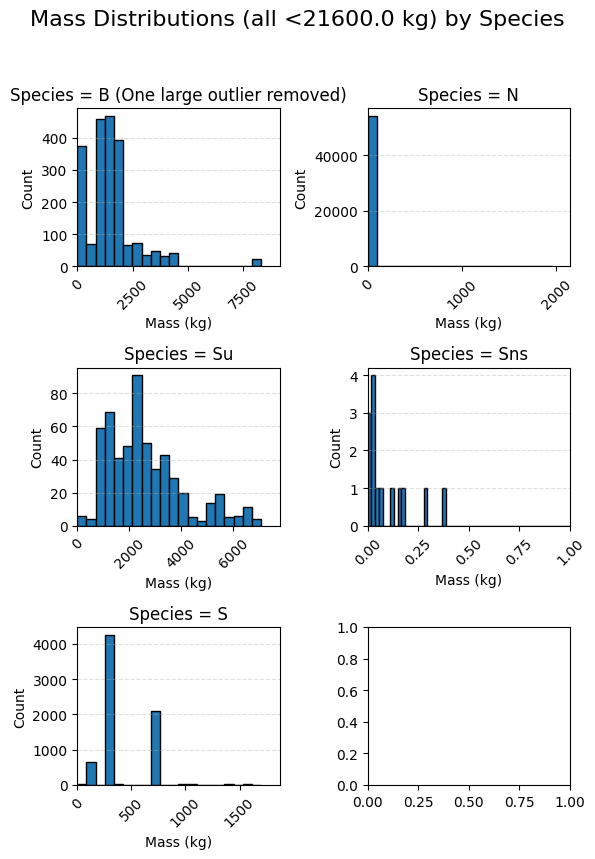

In [84]:
all_species = assigned_df['species_class'].dropna().unique()
bins = np.arange(0, 8000, 100)
plt.figure(figsize=(6,4))

for species in all_species:
    mask = (assigned_df['mass'] < max_mass) & (assigned_df['species_class'] == species)
    subset = assigned_df.loc[mask, 'mass'].dropna()
    # overlay each species, with a bit of transparency
    plt.hist(subset, bins=bins, alpha=0.5, label=species, edgecolor='black')

plt.title(f"Log Scale Mass Distribution (<{max_mass} kg) by Species")
plt.xlabel("Mass (kg)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Species")
plt.yscale('log')

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


n = len(all_species)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()

for ax, sp in zip(axes, all_species):
    data = assigned_df.loc[
        (assigned_df['species_class']==sp) & 
        (assigned_df['mass'] < max_mass),
        'mass'
    ].dropna()
    
    max_data_mass = data.max() if not data.empty else 0
    print(f"Length of data for {sp}: {len(data)}")

    bins_sp = np.arange(0, max_data_mass + 30, max_data_mass / 20)
    ax.hist(data, bins=bins_sp, edgecolor='black')
    
    if sp != "B":
        ax.set_title(f"Species = {sp}")
    else:
        ax.set_title(f"Species = {sp} (One large outlier removed)")

    if max_data_mass > 1:
        ax.set_xlim(0, max_data_mass+(max_data_mass*0.1))  # Add 10% margin to the max mass
    else:
        ax.set_xlim(0, 1)
    
    ax.set_xlabel("Mass (kg)")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    # if sp == "Sns":
    #     print(f"All data for {sp}:\n{data.describe()}")
    #     print(list(data))

fig.suptitle(f"Mass Distributions (all <{max_mass} kg) by Species", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


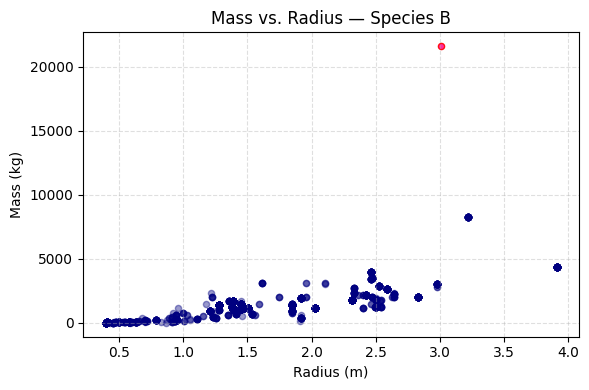

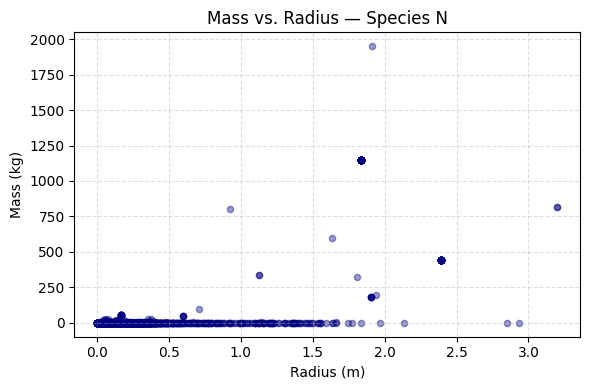

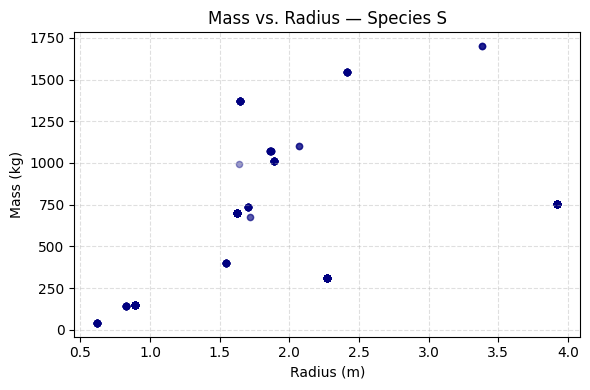

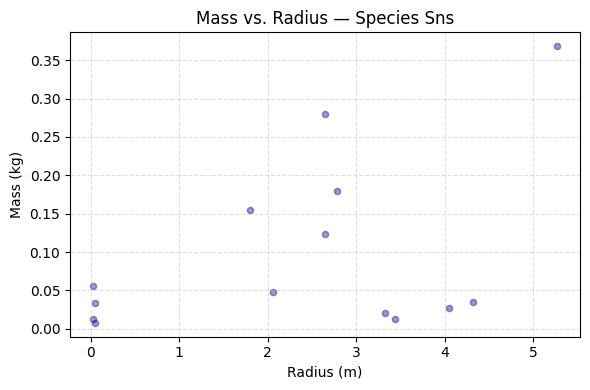

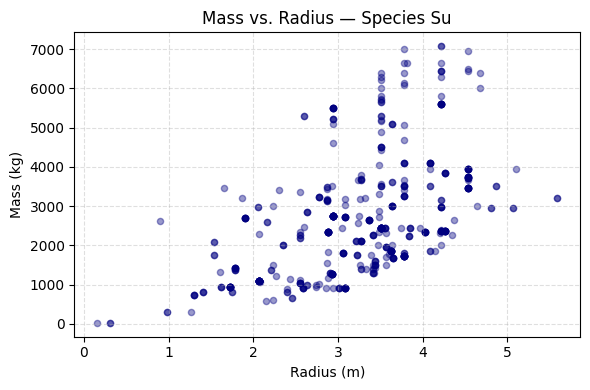

In [85]:
mass_radius_df = assigned_df[['species_class','mass','diam_char']].dropna()
mass_radius_df['radius'] = mass_radius_df['diam_char'] / 2

for sp, group in mass_radius_df.groupby('species_class'):
    plt.figure(figsize=(6,4))

    
    if remove_outliers:
        big_mass_points = group['mass'] > big_mass
    
    # Plot normal points
    plt.scatter(
        group.loc[~big_mass_points, 'radius'],
        group.loc[~big_mass_points, 'mass'],
        s=20, alpha=0.4, color = 'navy', label='not outlier'
    )

    plt.scatter(
        group.loc[big_mass_points, 'radius'],
        group.loc[big_mass_points, 'mass'],
        s=20, alpha=0.9, color='deeppink', edgecolor='red', label='outlier'
    )
    
    plt.title(f"Mass vs. Radius — Species {sp}")
    plt.xlabel("Radius (m)")
    plt.ylabel("Mass (kg)")
    plt.grid(True, linestyle='--', alpha=0.4)
    
    plt.tight_layout()
    plt.show()

### New Statistical Analysis

In [86]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

NOTE: K medoids take much longer to compute. Select the following boolean as needed!

In [87]:
# Set to True to include KMedoids clustering
include_medoids = True  

We removed the following B outliers:
         radius     mass
22644  3.006738  21600.0


/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/pyth

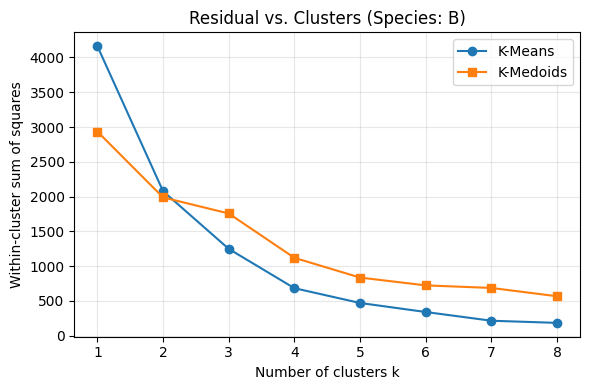

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/pyth

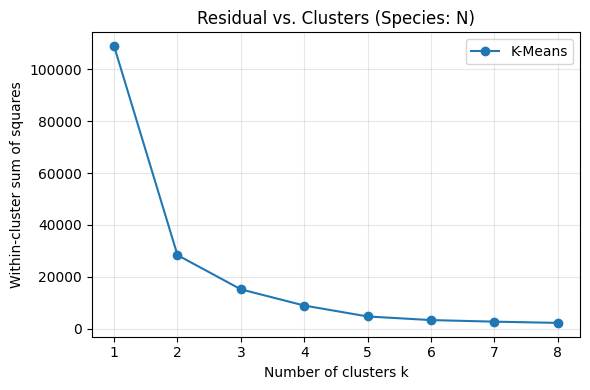

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/pyth

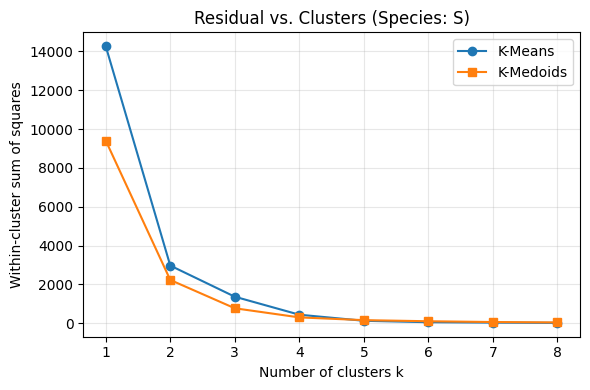

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/pyth

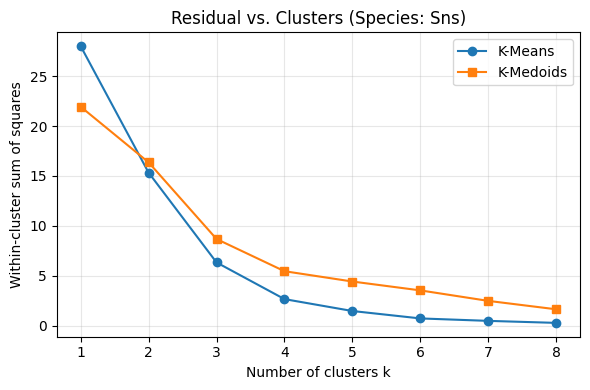

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/pyth

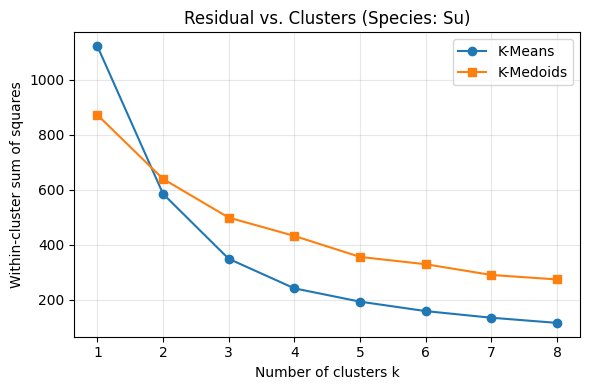

In [88]:
species_groups = mass_radius_df.groupby('species_class')
Xs_by_species = {}
cleaned_groups = {}

for sp, group in species_groups:
    
    # clean up outlier
    if sp == "B":
        B_outliers = group[group['mass'] >= big_mass]
        print("We removed the following B outliers:")
        print(B_outliers[['radius', 'mass']])
        
        group = group[group['mass'] < big_mass]
    cleaned_groups[sp] = group
        
    df = group[['radius', 'mass']].dropna()
    X = df.values
    Xs_by_species[sp] = StandardScaler().fit_transform(X)
    Xs = Xs_by_species[sp] # for use in the loop below
    
    inertia_kmeans  = []
    resid_kmedians  = []
    
    # Computer WCSS (intertia) for k = 1, ..., 8
    ks = range(1,9)
    for k in ks:
        km = KMeans(n_clusters=k, random_state=0).fit(Xs)
        inertia_kmeans.append(km.inertia_)  
        
        # k-medians
        if include_medoids and sp!="N":
            kmn = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0).fit(Xs)
            # sum of L1 distances to each cluster’s medoid
            # resid = np.sum(kmn.inertia_)  # sklearn_extra uses ‘inertia_’ as sum of distances
            # resid_kmedians.append(resid)
            resid_kmedians.append(kmn.inertia_)
    
    # plot elbow
    plt.figure(figsize=(6, 4))
    plt.plot(ks, inertia_kmeans, '-o', label='K-Means')
    if include_medoids and sp!="N":
        plt.plot(ks, resid_kmedians, '-s', label='K-Medoids')
    plt.xticks(ks)
    plt.xlabel('Number of clusters k')
    plt.ylabel('Within-cluster sum of squares')
    plt.title(f'Residual vs. Clusters (Species: {sp})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


From this, I think the following # clusters make most sense:
- B: 2
- N: 2
- S: 2
- SnS: 3
- Su: 3

In [89]:
species_names = list(Xs_by_species.keys())
species_names

['B', 'N', 'S', 'Sns', 'Su']

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


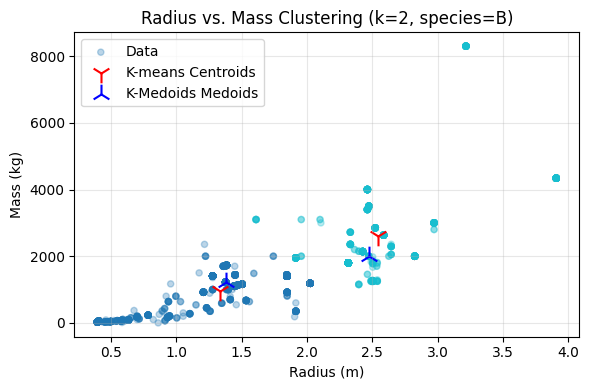

length of data for species B: 2081
K-means centroid coordinates (radius (m), mass (kg)) for species B (k=2):
  Cluster 1: (1.33870, 960.54715)
  Cluster 2: (2.54635, 2598.82931)
K-Medoids centroid coordinates (radius (m), mass (kg)) for species B (k=2):
  Medoid 1: (1.37819, 1220.00000)
  Medoid 2: (2.47417, 2000.00000)


/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


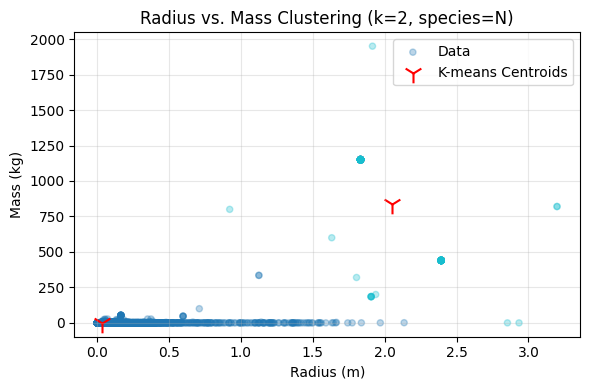

length of data for species N: 54441
K-means centroid coordinates (radius (m), mass (kg)) for species N (k=2):
  Cluster 1: (0.03406, 0.08622)
  Cluster 2: (2.05440, 838.15373)


/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


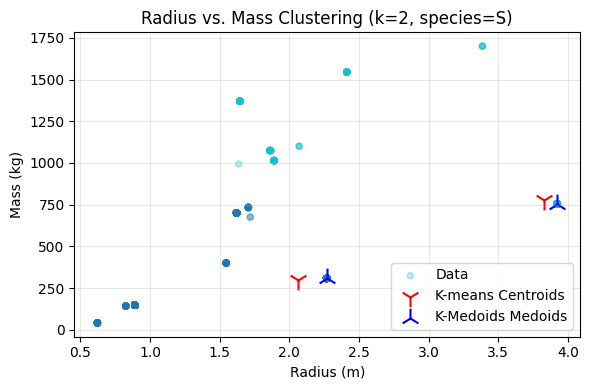

length of data for species S: 7137
K-means centroid coordinates (radius (m), mass (kg)) for species S (k=2):
  Cluster 1: (2.06569, 297.40306)
  Cluster 2: (3.83171, 777.25318)
K-Medoids centroid coordinates (radius (m), mass (kg)) for species S (k=2):
  Medoid 1: (2.26867, 308.00000)
  Medoid 2: (3.92172, 754.00000)


/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


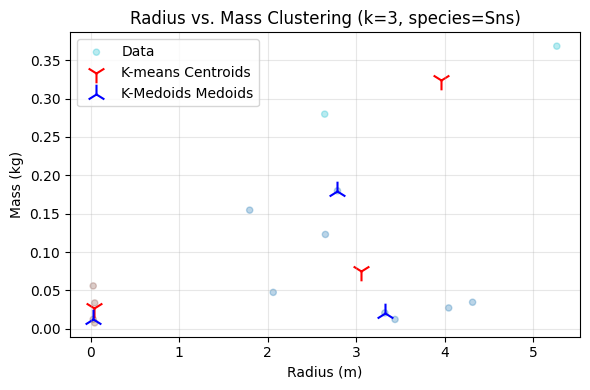

length of data for species Sns: 14
K-means centroid coordinates (radius (m), mass (kg)) for species Sns (k=3):
  Cluster 1: (3.05161, 0.07487)
  Cluster 2: (0.03594, 0.02730)
  Cluster 3: (3.95431, 0.32410)
K-Medoids centroid coordinates (radius (m), mass (kg)) for species Sns (k=3):
  Medoid 1: (0.02746, 0.01220)
  Medoid 2: (2.78735, 0.17980)
  Medoid 3: (3.32245, 0.02060)


/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


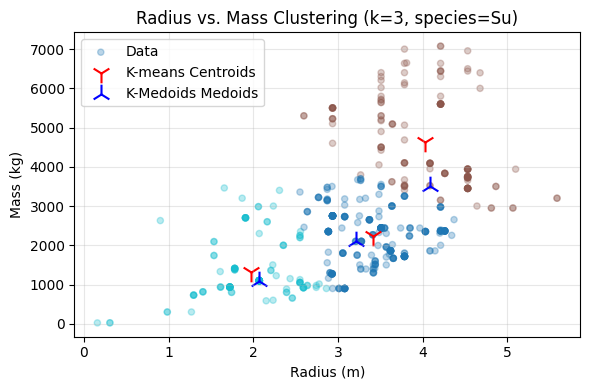

length of data for species Su: 561
K-means centroid coordinates (radius (m), mass (kg)) for species Su (k=3):
  Cluster 1: (3.41393, 2239.06441)
  Cluster 2: (4.02741, 4641.26812)
  Cluster 3: (1.97574, 1330.19531)
K-Medoids centroid coordinates (radius (m), mass (kg)) for species Su (k=3):
  Medoid 1: (4.08758, 3520.00000)
  Medoid 2: (3.20962, 2100.00000)
  Medoid 3: (2.07059, 1100.00000)


In [90]:
# Cluster fit on K-means
species_names = list(Xs_by_species.keys())
k_list = [2, 2, 2, 3, 3]

for i, sp in enumerate(species_names):
    X = Xs_by_species[sp]
    k = k_list[i]
    group = cleaned_groups[sp]
    
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = km.labels_
    
    # unscale centers before plotting!
    scaler = StandardScaler().fit(group[['radius', 'mass']].dropna().values)
    centers_scaled = km.cluster_centers_
    centers_unscaled = scaler.inverse_transform(centers_scaled)
    
    if include_medoids and sp != "N":
        kmn = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0).fit(X)
        labels_medoids = kmn.labels_
        medoids = kmn.cluster_centers_
        medoids_unscaled = scaler.inverse_transform(medoids)

    
    df = group[['radius', 'mass']].dropna()
    
    plt.figure(figsize=(6, 4))
    plt.scatter(df['radius'], df['mass'], c=labels, cmap='tab10', s=20, alpha=0.3, label='Data')
    plt.scatter(centers_unscaled[:, 0], centers_unscaled[:, 1],
                marker='1', c='red', s=200, label='K-means Centroids')
    if include_medoids and sp != "N":
        plt.scatter(medoids_unscaled[:, 0], medoids_unscaled[:, 1],
                marker='2', c='blue', s=200, label='K-Medoids Medoids' if include_medoids else None)
    plt.xlabel('Radius (m)')
    plt.ylabel('Mass (kg)')
    plt.title(f'Radius vs. Mass Clustering (k={k}, species={sp})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"length of data for species {sp}: {len(df)}")
    
    print(f"K-means centroid coordinates (radius (m), mass (kg)) for species {sp} (k={k}):")
    for j, center in enumerate(centers_unscaled):
        print(f"  Cluster {j+1}: ({center[0]:.5f}, {center[1]:.5f})")
     
    if include_medoids and sp != "N":
        print(f"K-Medoids centroid coordinates (radius (m), mass (kg)) for species {sp} (k={k}):")
        for j, medoid in enumerate(medoids_unscaled):
            print(f"  Medoid {j+1}: ({medoid[0]:.5f}, {medoid[1]:.5f})")
    

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/pyth

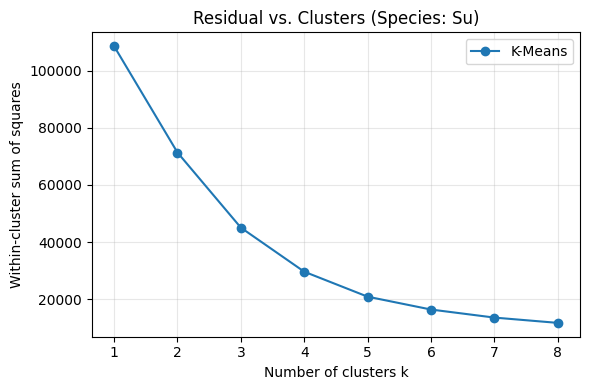

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


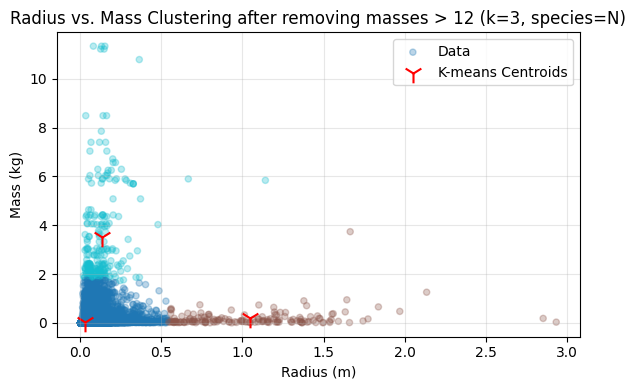

K-means centroid coordinates (radius (m), mass (kg)) for species N (k=2):
  Cluster 1: (0.03059, 0.03521)
  Cluster 2: (1.04551, 0.18550)
  Cluster 3: (0.13269, 3.53465)


In [91]:
# we will try clustering with 2 clusters, for N after removing outlier.
N_noutlier = mass_radius_df[mass_radius_df['species_class']=='N'].copy()
N_noutlier = N_noutlier[N_noutlier['mass'] < 12]  # remove outlier

X_N = N_noutlier[['radius', 'mass']].dropna().values
X_N_scaled = StandardScaler().fit_transform(X_N)

inertia_kmeans  = []
resid_kmedians  = []
    
# elbow
ks = range(1,9)
for k in ks:
    km = KMeans(n_clusters=k, random_state=0).fit(X_N_scaled)
    inertia_kmeans.append(km.inertia_)  
    
    # plot elbow
plt.figure(figsize=(6, 4))
plt.plot(ks, inertia_kmeans, '-o', label='K-Means')
plt.xticks(ks)
plt.xlabel('Number of clusters k')
plt.ylabel('Within-cluster sum of squares')
plt.title(f'Residual vs. Clusters (Species: {sp})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# find clusters
km_N = KMeans(n_clusters=3, random_state=0).fit(X_N_scaled)

labels_N = km_N.labels_
centers_N_scaled = km_N.cluster_centers_


# unscale centers for plotting
scaler_N = StandardScaler().fit(X_N)
centers_N_unscaled = scaler_N.inverse_transform(centers_N_scaled)
# Plot the results
plt.figure(figsize=(6, 4))
plt.scatter(X_N[:, 0], X_N[:, 1], c=labels_N, cmap='tab10', s=20, alpha=0.3, label='Data')      
plt.scatter(centers_N_unscaled[:, 0], centers_N_unscaled[:, 1],
                marker='1', c='red', s=200, label='K-means Centroids')

plt.xlabel('Radius (m)')
plt.ylabel('Mass (kg)')
plt.title(f'Radius vs. Mass Clustering after removing masses > 12 (k=3, species=N)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# print the coordinates of the centers
print(f"K-means centroid coordinates (radius (m), mass (kg)) for species N (k=2):")
for j, center in enumerate(centers_N_unscaled):
    print(f"  Cluster {j+1}: ({center[0]:.5f}, {center[1]:.5f})")


## Time and Phase related study

In [ ]:
# Filter to Sns
sns = T_new[T_new['species_class']=='Sns']
s = T_new[T_new['species_class']=='S']
n = T_new[T_new['species_class']=='N']
b = T_new[T_new['species_class']=='B']

print("\nPhase descriptions for Sns:")
print(sns['phase_desc'].value_counts())

print("\nPhase descriptions for S:")
print(s['phase_desc'].value_counts())

print("\nPhase descriptions for N:")
print(n['phase_desc'].value_counts())

print("\nPhase descriptions for B:")
print(b['phase_desc'].value_counts())


In [ ]:
# 1) Build date_start if you haven’t already
T_new['date_start'] = pd.to_datetime({
    'year':  T_new.year_start.astype(int),
    'month': T_new.month_start.astype(int),
    'day':   T_new.day_start.astype(int)
})

# 2) Create yearly bins from min to max year
year_min = T_new['date_start'].dt.year.min()
year_max = T_new['date_start'].dt.year.max()
bins = pd.date_range(start=f"{year_min}-01-01", 
                     end=f"{year_max+1}-01-01", 
                     freq='YS')  # Year Start

# 3) Plot histogram with date bins
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(T_new['date_start'], bins=bins, edgecolor='black')

# 4) bin edges as ticks, label by year
ax.set_xticks(bins)
ax.set_xticklabels([dt.year for dt in bins], rotation=90, ha='right')

# 5) Beautify
ax.set_title('Histogram of Start Dates (1 Bin per Year): SEP1')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
df = T_new.set_index('date_start')
mass_total = df['mass'].resample('A').sum()  

# 4) Mass per phase each year
mass_main    = df[df['phase']==2]['mass'].resample('A').sum()
mass_disposal= df[df['phase']==3]['mass'].resample('A').sum()
mass_debris  = df[df['phase']==4]['mass'].resample('A').sum()

plt.figure(figsize=(10,5))
plt.plot(mass_total.index.year,    mass_total,     label='Total Mass')
plt.plot(mass_main.index.year,     mass_main,      label='Operational (phase 2)')
plt.plot(mass_disposal.index.year, mass_disposal,  label='Disposal (phase 3)')
plt.plot(mass_debris.index.year,   mass_debris,    label='Derelict (phase 4)')

plt.xlabel('Year')
plt.ylabel('Mass in Orbit (kg)')
plt.title('Time-Resolved Mass Inventory by Phase')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# 1) Ensure you have a datetime column called date_start
T_new['date_start'] = pd.to_datetime({
    'year':  T_new.year_start.astype(int),
    'month': T_new.month_start.astype(int),
    'day':   T_new.day_start.astype(int)
})

# 2) Aggregate into one count per calendar year
annual_counts = T_new['date_start'].dt.year.value_counts().sort_index()

# 3) Plot as a bar chart, one bar per year, ticks every 5 years
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(annual_counts.index, annual_counts.values, width=0.8, edgecolor='black')

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(annual_counts.index, rotation=45, ha='right')

ax.set_title('Histogram of Start Dates (1 Bin per Year): SEP3H')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print(T_new['date_start'].min())
print(T_new['date_start'].max())

In [ ]:
# # 1) sim start date
# start_date = "01/01/2025"
# month, day, year = map(int, start_date.split("/"))

# # 2) Convert to Modified Julian Date
# t0 = Time(f"{year}-{month:02d}-{day:02d}", format="iso", scale="utc")
# mjd0 = t0.mjd
# print(f"Simulation t₀ = {start_date} → MJD {mjd0:.6f}")

# # 3) Filter your DataFrame
# #    Keep only objects whose mjd_start is ≤ mjd0 (i.e. in orbit by t₀)
# initial = T_new.loc[T_new['mjd_start'] <= mjd0].copy()

# # 4) Sanity check
# print(f"Total objects in table:        {len(T_new)}")
# print(f"Objects in initial population: {len(initial)}")
# print(f"Objects launched after t₀:     {(T_new['mjd_start'] > mjd0).sum()}")

# # 5) Now plot or analyze `initial` only
# #    e.g. mass histogram for initial population:
# import matplotlib.pyplot as plt
# plt.hist(initial['mass'].dropna(), bins=50, edgecolor='black')
# plt.title(f"Mass Distribution of Initial Population\n(before or on {start_date})")
# plt.xlabel("Mass (kg)")
# plt.ylabel("Count")
# plt.grid(alpha=0.4)
# plt.tight_layout()
# plt.show()


## Preliminary Plotting, All Species

In [ ]:
max_mass = 10000
heavy = T_new[T_new['mass'] > max_mass]

print(f"Number of objects > {max_mass} kg: {len(heavy)}")
print(heavy['species_class'].value_counts())

# max_mass_i = 10000
# heavy_i = initial[initial['mass'] > max_mass_i]

# print(f"Number of objects > {max_mass_i} kg: {len(heavy_i)}")
# print(heavy_i['species_class'].value_counts())


In [ ]:
all_species = T_new['species_class'].dropna().unique()
bins = np.arange(0, max_mass + 500, 100)
plt.figure(figsize=(6,4))

for species in all_species:
    mask = (T_new['mass'] < max_mass) & (T_new['species_class'] == species)
    subset = T_new.loc[mask, 'mass'].dropna()
    # overlay each species, with a bit of transparency
    plt.hist(subset, bins=bins, alpha=0.5, label=species, edgecolor='black')

plt.title(f"Mass Distribution (<{max_mass} kg) by Species")
plt.xlabel("Mass (kg)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Species")

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


n = len(all_species)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()

for ax, sp in zip(axes, all_species):
    data = T_new.loc[
        (T_new['species_class']==sp) & 
        (T_new['mass'] < max_mass),
        'mass'
    ].dropna()

    ax.hist(data, bins=bins, edgecolor='black')
    ax.set_title(f"Species = {sp}")
    ax.set_xlim(0, max_mass)
    ax.set_xlabel("Mass (kg)")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

fig.suptitle(f"Mass Distributions (<{max_mass} kg) by Species", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
all_species = T_new['species_class'].dropna().unique()
bins = 60
plt.figure(figsize=(6,4))

for species in all_species:
    mask = (T_new['species_class'] == species)
    subset = T_new.loc[mask, 'radius'].dropna()
    plt.hist(subset, bins=bins, alpha=0.5, label=species, edgecolor='black')

plt.title(f"Radius Distribution by Species")
plt.xlabel("Radius (m)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Species")

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


n = len(all_species)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()

for ax, sp in zip(axes, all_species):
    data = T_new.loc[
        (T_new['species_class']==sp),
        # (T_new['mass'] < max_mass),
        'radius'
    ].dropna()

    ax.hist(data, bins=bins, edgecolor='black')
    ax.set_title(f"Species = {sp}")
    # ax.set_xlim(0, max_mass)
    ax.set_xlabel("Radius (m)")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

fig.suptitle(f"Radius Distributions by Species", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# pick only the rows with both mass & radius
mass_radius_df = T_new[['species_class','mass','radius']].dropna()

for sp, group in mass_radius_df.groupby('species_class'):
    plt.figure(figsize=(6,4))
    plt.scatter(
        group['radius'],
        group['mass'],
        s=20,
        alpha=0.6,
        edgecolor='k'
    )
    plt.title(f"Mass vs. Radius — Species {sp}")
    plt.xlabel("Radius (m)")
    plt.ylabel("Mass (kg)")
    plt.grid(True, linestyle='--', alpha=0.4)
    # optional log scale if needed:
    # plt.xscale('log'); plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # TODO:
    # check how many points to verify:
# Species class distribution:
# species_class
# N          54704
# S           6906
# Sns         3356
# Unknown     2536
# B           2082


## Statistical Analysis

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

In [ ]:
# mass_radius_df = T_new[['species_class','mass','radius']].dropna()
species_groups = mass_radius_df.groupby('species_class')

In [ ]:
# 1) Prepare your data: pick only the species you want (e.g. S, station-keeping sats)
df = T_new[T_new['species_class']=='S'][['radius','mass']].dropna()
X = df.values
Xs = StandardScaler().fit_transform(X)

inertia_kmeans  = []
resid_kmedians  = []

# 2) Compute WCSS (inertia) for k = 1…8
ks = range(1,9)
for k in ks:
    km = KMeans(n_clusters=k, random_state=0).fit(Xs)
    inertia_kmeans.append(km.inertia_)  
    
    # k-medians
    kmn = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0)
    kmn.fit(Xs)
    # sum of L1 distances to each cluster’s medoid
    resid = np.sum(kmn.inertia_)  # sklearn_extra uses ‘inertia_’ as sum of distances
    resid_kmedians.append(resid)

# 3) Plot the elbow
plt.figure(figsize=(6,3))
plt.plot(ks, inertia_kmeans, '-o', label='K-Means Inertia')
plt.xticks(ks)
plt.xlabel('Number of clusters k')
plt.ylabel('Within-cluster sum of squares')
plt.title('Residual vs. Clusters (Species S)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# TODO: check more into the elbow method and include for all species

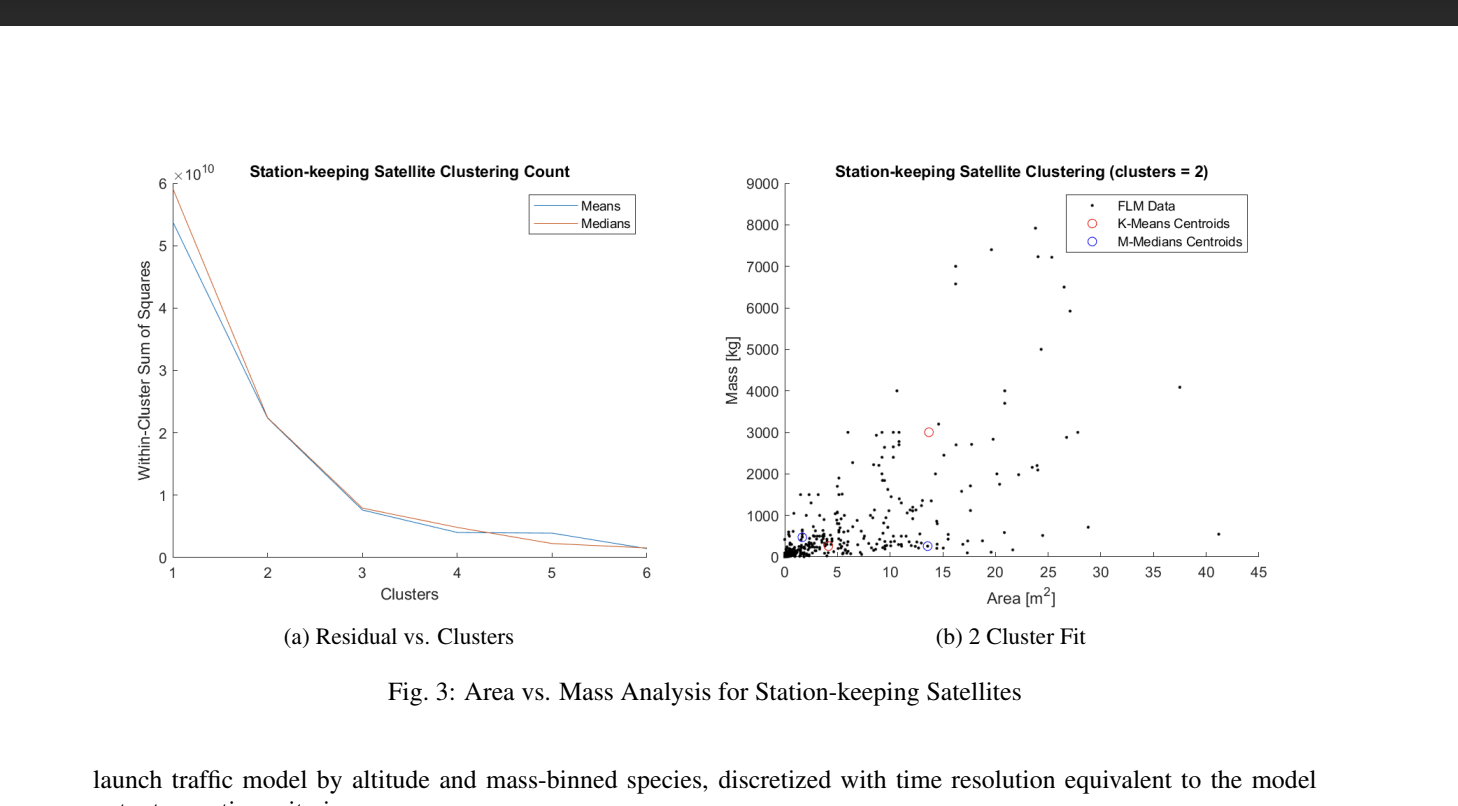

In [ ]:

k = 3
km = KMeans(n_clusters=k, random_state=0).fit(X)
labels = km.labels_
centers = km.cluster_centers_

# 5) Scatter Area vs Mass with centroids
plt.figure(figsize=(6,4))
plt.scatter(df['radius'], df['mass'], c=labels, cmap='tab10', s=20, alpha=0.6, label='Data')
plt.scatter(centers[:,0], centers[:,1], 
            marker='X', s=200, c='black', label='Centroids')
plt.xlabel('Radius (m)')
plt.ylabel('Mass (kg)')
plt.title(f'Radius vs. Mass Clustering (k={k})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()